In [1]:
from medpy.metric.binary import hd, hd95, dc, jc, assd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F
import os, sys, cv2
import matplotlib.pyplot as plt

sys.path.append('/raid/wjc/code/xbound_former')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from lib.xboundformer import _segm_pvtv2

target_size = (512, 512)
model = _segm_pvtv2(1, 1, 1, 1, 352).to(device)        
model.load_state_dict(
    torch.load(
        f'logs/isbi2016/test_loss_1_aug_1/bl_1_1/fold_0/model/best.pkl'
    ))
print('Model Loaded...')

Model Loaded...


In [2]:
fold = 'PH2'
model.eval()
from utils.isbi2016_new import norm01, myDataset
if fold == 'PH2':
    dataset = myDataset(split='test', aug=False)
else:
    dataset = myDataset(split='valid', aug=False)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=1)


Loaded 200 frames


In [3]:
datas = []
labels = []
outputs = []
for batch_idx, batch_data in tqdm(enumerate(test_loader)):
    data = batch_data['image'].to(device).float()
    label = batch_data['label'].to(device).float()
    path = batch_data['image_path'][0]
    with torch.no_grad():
        output, point_pred1, point_pred2, point_pred3 = model(data)
    output = torch.sigmoid(output)[0][0]
    output = (output.cpu().numpy() > 0.5).astype('uint8')
    output = (cv2.resize(output, target_size, cv2.INTER_NEAREST) >
              0.5) * 1
    image = batch_data['image'][0].numpy().transpose(1,2,0)
    label = batch_data['label'][0,0]
    datas.append(image)
    labels.append(label)
    outputs.append(output)

200it [00:13, 14.96it/s]


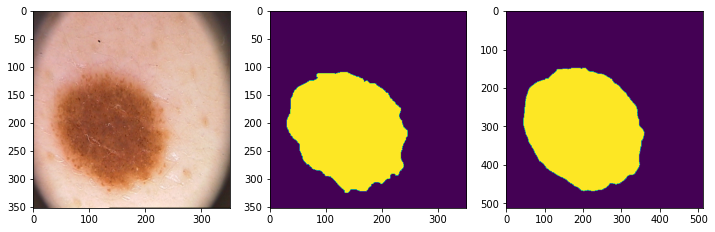

In [27]:
import random
_id = random.randint(0,len(datas)-1)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(datas[_id])
plt.subplot(1,3,2)
plt.imshow(labels[_id])
plt.subplot(1,3,3)

plt.imshow(outputs[_id])